In [143]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error # as cost function, to be used in RMSE
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz  
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from datetime import datetime
seed = 0 # initialize consistent random_state

In [3]:
cleaned = pd.read_csv('cleaned_wonder_LifeYrsLostAdded10212023.csv')
cleaned

,Multiple Cause of death,Multiple Cause of death Code,Year,Year Code,Gender,Gender Code,Race,Race Code,Five-Year Age Groups,Five-Year Age Groups Code,Deaths,Population,Crude Rate,socioec quintile,age_midpoint,LifeYearsLostUnit,LifeYearsLostTotal
0,Opium,T40.0,2001,2001,Female,F,White,2106-3,40-44 years,40-44,5,1783717,0.280314,1,42.0,40.836526,204.182632
1,Opium,T40.0,2003,2003,Female,F,Black or African American,2054-5,25-29 years,25-29,5,330059,1.514881,1,27.0,55.093136,275.465681
2,Opium,T40.0,2003,2003,Female,F,White,2106-3,40-44 years,40-44,5,1765457,0.283213,1,42.0,40.836526,204.182632
3,Opium,T40.0,2003,2003,Female,F,White,2106-3,60-64 years,60-64,5,1217522,0.410670,1,62.0,23.087362,115.436812
4,Opium,T40.0,2004,2004,Female,F,White,2106-3,40-44 years,40-44,5,1758221,0.284378,1,42.0,40.836526,204.182632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28237,Other and unspecified narcotics,T40.6,2020,2020,Male,M,White,2106-3,55-59 years,55-59,22,1770448,1.242623,5,57.0,24.069470,529.528347
28238,Other and unspecified narcotics,T40.6,2020,2020,Male,M,White,2106-3,65-69 years,65-69,5,1328961,0.376234,5,67.0,16.650282,83.251408
28239,Other and unspecified narcotics,T40.6,2020,2020,Male,M,White,2106-3,70-74 years,70-74,5,1068045,0.468145,5,72.0,13.226478,66.132390
28240,Other and unspecified narcotics,T40.6,2020,2020,Male,M,White,2106-3,75-79 years,75-79,5,702229,0.712018,5,77.0,10.078020,50.390101


In [6]:
fentanyl = cleaned[cleaned['Multiple Cause of death'] == 'Other synthetic narcotics'].copy()
fentanyl

,Multiple Cause of death,Multiple Cause of death Code,Year,Year Code,Gender,Gender Code,Race,Race Code,Five-Year Age Groups,Five-Year Age Groups Code,Deaths,Population,Crude Rate,socioec quintile,age_midpoint,LifeYearsLostUnit,LifeYearsLostTotal
3548,Other synthetic narcotics,T40.4,1999,1999,Female,F,American Indian or Alaska Native,1002-5,25-29 years,25-29,5,35278,14.173139,1,27.0,55.093136,275.465681
3549,Other synthetic narcotics,T40.4,1999,1999,Female,F,American Indian or Alaska Native,1002-5,40-44 years,40-44,5,38192,13.091747,1,42.0,40.836526,204.182632
3550,Other synthetic narcotics,T40.4,1999,1999,Female,F,Asian or Pacific Islander,A-PI,40-44 years,40-44,5,28791,17.366538,1,42.0,40.836526,204.182632
3551,Other synthetic narcotics,T40.4,1999,1999,Female,F,Asian or Pacific Islander,A-PI,45-49 years,45-49,5,26161,19.112419,1,47.0,36.189998,180.949989
3552,Other synthetic narcotics,T40.4,1999,1999,Female,F,Black or African American,2054-5,20-24 years,20-24,5,369758,1.352236,1,22.0,59.935205,299.676025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27138,Other synthetic narcotics,T40.4,2020,2020,Male,M,White,2106-3,60-64 years,60-64,281,1637972,17.155360,5,62.0,20.240088,5687.464734
27139,Other synthetic narcotics,T40.4,2020,2020,Male,M,White,2106-3,65-69 years,65-69,112,1328961,8.427636,5,67.0,16.650282,1864.831531
27140,Other synthetic narcotics,T40.4,2020,2020,Male,M,White,2106-3,70-74 years,70-74,22,1068045,2.059838,5,72.0,13.226478,290.982518
27141,Other synthetic narcotics,T40.4,2020,2020,Male,M,White,2106-3,75-79 years,75-79,5,702229,0.712018,5,77.0,10.078020,50.390101


# Manage Outliers
Do we want to ignore outliers? They are some of the few data points where we have actual data and are not using our artificial "suppressed" average of 5 deaths. 

We can do this per socioeconomic quintile or any of the other features, but I do so for the entire dataset

For now, I identify using the IQR and consider anything outside the 1.5 * upper or lower bounds as an outlier. We can also do 3 standard deviations away

In [30]:
# identify interquartile range as the bounds
fentanyl_outliers_working = fentanyl.copy()

# set opiod index to column to reset index
fentanyl_outliers_working['narcotics_index'] = fentanyl_outliers_working.index
fentanyl_outliers_working = fentanyl_outliers_working.reset_index(drop = True) #reset_index creates redundant index col

# calculate upper and lower bounds
print(f'Original data shape: {fentanyl.shape[0]}')
Q1 = fentanyl_outliers_working['Crude Rate'].quantile(0.25)
Q3 = fentanyl_outliers_working['Crude Rate'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - (1.5 * IQR)
upper = Q3 + (1.5 * IQR)
 
# indices of outlier rows
outliers_beyond_upper = np.where(fentanyl_outliers_working['Crude Rate'] >= upper)[0]
outliers_beyond_lower = np.where(fentanyl_outliers_working['Crude Rate'] <= lower)[0]
# print(outliers_beyond_lower)
# print(outliers_beyond_upper)
outliers_arr = np.append(outliers_beyond_upper , outliers_beyond_lower)
print(f'Number of outliers: {len(outliers_arr)}')
fentanyl_working
fentanyl_outliers_removed = fentanyl_outliers_working.drop(index = outliers_arr)
fentanyl_outliers_removed

Original data shape: 5578
Number of outliers: 360


,Multiple Cause of death,Multiple Cause of death Code,Year,Year Code,Gender,Gender Code,Race,Race Code,Five-Year Age Groups,Five-Year Age Groups Code,Deaths,Population,Crude Rate,socioec quintile,age_midpoint,LifeYearsLostUnit,LifeYearsLostTotal,narcotics_index
0,Other synthetic narcotics,T40.4,1999,1999,Female,F,American Indian or Alaska Native,1002-5,25-29 years,25-29,5,35278,14.173139,1,27.0,55.093136,275.465681,3548
1,Other synthetic narcotics,T40.4,1999,1999,Female,F,American Indian or Alaska Native,1002-5,40-44 years,40-44,5,38192,13.091747,1,42.0,40.836526,204.182632,3549
2,Other synthetic narcotics,T40.4,1999,1999,Female,F,Asian or Pacific Islander,A-PI,40-44 years,40-44,5,28791,17.366538,1,42.0,40.836526,204.182632,3550
3,Other synthetic narcotics,T40.4,1999,1999,Female,F,Asian or Pacific Islander,A-PI,45-49 years,45-49,5,26161,19.112419,1,47.0,36.189998,180.949989,3551
4,Other synthetic narcotics,T40.4,1999,1999,Female,F,Black or African American,2054-5,20-24 years,20-24,5,369758,1.352236,1,22.0,59.935205,299.676025,3552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5573,Other synthetic narcotics,T40.4,2020,2020,Male,M,White,2106-3,60-64 years,60-64,281,1637972,17.155360,5,62.0,20.240088,5687.464734,27138
5574,Other synthetic narcotics,T40.4,2020,2020,Male,M,White,2106-3,65-69 years,65-69,112,1328961,8.427636,5,67.0,16.650282,1864.831531,27139
5575,Other synthetic narcotics,T40.4,2020,2020,Male,M,White,2106-3,70-74 years,70-74,22,1068045,2.059838,5,72.0,13.226478,290.982518,27140
5576,Other synthetic narcotics,T40.4,2020,2020,Male,M,White,2106-3,75-79 years,75-79,5,702229,0.712018,5,77.0,10.078020,50.390101,27141


# Decide dataset to use
Can use either fentanyl_outliers_removed or original fentanyl, but set fentanyl_bronze as starting "dataset to be used throughout"

For now, predict only crude rate (y), but we can do all the same below by switching to life years lost

In [51]:
# features and labels
x_cols = ['Year', 'Gender', 'Race', 'Five-Year Age Groups', 'Population', 'socioec quintile']
y_col = ['Crude Rate']

# select dataset to use
fentanyl_bronze = fentanyl.loc[:, np.append(x_cols, y_col)].copy() #or #fentanyl_outliers_removed.copy()
# fentanyl_bronze.reset_index(inplace = True, drop = True).drop()
fentanyl_bronze

,Year,Gender,Race,Five-Year Age Groups,Population,socioec quintile,Crude Rate
3548,1999,Female,American Indian or Alaska Native,25-29 years,35278,1,14.173139
3549,1999,Female,American Indian or Alaska Native,40-44 years,38192,1,13.091747
3550,1999,Female,Asian or Pacific Islander,40-44 years,28791,1,17.366538
3551,1999,Female,Asian or Pacific Islander,45-49 years,26161,1,19.112419
3552,1999,Female,Black or African American,20-24 years,369758,1,1.352236
...,...,...,...,...,...,...,...
27138,2020,Male,White,60-64 years,1637972,5,17.155360
27139,2020,Male,White,65-69 years,1328961,5,8.427636
27140,2020,Male,White,70-74 years,1068045,5,2.059838
27141,2020,Male,White,75-79 years,702229,5,0.712018


In [54]:
fentanyl_silver = pd.get_dummies(fentanyl_bronze)
fentanyl_silver

,Year,Population,socioec quintile,Crude Rate,Gender_Female,Gender_Male,Race_American Indian or Alaska Native,Race_Asian or Pacific Islander,Race_Black or African American,Race_White,...,Five-Year Age Groups_45-49 years,Five-Year Age Groups_5-9 years,Five-Year Age Groups_50-54 years,Five-Year Age Groups_55-59 years,Five-Year Age Groups_60-64 years,Five-Year Age Groups_65-69 years,Five-Year Age Groups_70-74 years,Five-Year Age Groups_75-79 years,Five-Year Age Groups_80-84 years,Five-Year Age Groups_< 1 year
3548,1999,35278,1,14.173139,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3549,1999,38192,1,13.091747,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3550,1999,28791,1,17.366538,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3551,1999,26161,1,19.112419,True,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False
3552,1999,369758,1,1.352236,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27138,2020,1637972,5,17.155360,False,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
27139,2020,1328961,5,8.427636,False,True,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
27140,2020,1068045,5,2.059838,False,True,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
27141,2020,702229,5,0.712018,False,True,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False


# Split data into test/train

In [55]:
x = fentanyl_silver.drop(y_col, axis = 1) # get only features
y = fentanyl_silver.loc[:, y_col]

x
# y

,Year,Population,socioec quintile,Gender_Female,Gender_Male,Race_American Indian or Alaska Native,Race_Asian or Pacific Islander,Race_Black or African American,Race_White,Five-Year Age Groups_1-4 years,...,Five-Year Age Groups_45-49 years,Five-Year Age Groups_5-9 years,Five-Year Age Groups_50-54 years,Five-Year Age Groups_55-59 years,Five-Year Age Groups_60-64 years,Five-Year Age Groups_65-69 years,Five-Year Age Groups_70-74 years,Five-Year Age Groups_75-79 years,Five-Year Age Groups_80-84 years,Five-Year Age Groups_< 1 year
3548,1999,35278,1,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3549,1999,38192,1,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3550,1999,28791,1,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3551,1999,26161,1,True,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3552,1999,369758,1,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27138,2020,1637972,5,False,True,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
27139,2020,1328961,5,False,True,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
27140,2020,1068045,5,False,True,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
27141,2020,702229,5,False,True,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False


In [73]:
# train/test set at 80/20 split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 28)
print(f'Training Features Shape: {x_train.shape}')
print(f'Training Labels Shape:  {x_test.shape}')
print(f'Testing Features Shape: {y_train.shape}')
print(f'Testing Labels Shape: {y_test.shape}')

Training Features Shape: (4462, 27)
Training Labels Shape:  (1116, 27)
Testing Features Shape: (4462, 1)
Testing Labels Shape: (1116, 1)


In [62]:
test_df = x_test.merge(y_test, left_index = True, right_index = True) #merge on index 
test_df

,Year,Population,socioec quintile,Gender_Female,Gender_Male,Race_American Indian or Alaska Native,Race_Asian or Pacific Islander,Race_Black or African American,Race_White,Five-Year Age Groups_1-4 years,...,Five-Year Age Groups_5-9 years,Five-Year Age Groups_50-54 years,Five-Year Age Groups_55-59 years,Five-Year Age Groups_60-64 years,Five-Year Age Groups_65-69 years,Five-Year Age Groups_70-74 years,Five-Year Age Groups_75-79 years,Five-Year Age Groups_80-84 years,Five-Year Age Groups_< 1 year,Crude Rate
20430,2000,1789402,4,False,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,0.279423
21036,2015,220496,4,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,2.267615
15700,2020,22306,3,True,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,22.415494
3883,2007,1721590,1,False,True,False,False,False,True,False,...,False,True,False,False,False,False,False,False,False,1.800661
9826,2016,34937,2,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,14.311475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20449,2001,984600,4,True,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,0.507820
26775,2016,121729,5,False,True,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,17.251436
15288,2014,370313,3,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,1.350209
9968,2017,1113358,2,False,True,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,0.449092


# Compare against using simple average
Compare any models against the error calculated from the simple average crude rate for the quintile

In [68]:
test_averages = test_df.groupby('socioec quintile', as_index = False).agg(quintile_ave = ('Crude Rate', 'mean'))
test_averages

,socioec quintile,quintile_ave
0,1,6.747311
1,2,7.823423
2,3,7.928443
3,4,6.335294
4,5,7.190898


In [70]:
test_df_ave_preds = test_df.merge(test_averages, on = 'socioec quintile')
print(f'Test df shape: {test_df_ave_preds.shape[0]}')

Test df shape: 1116


Finding the root mean square error involves calculating the residual for each observation (y – ŷ) and squaring it. Then sum all the squared residuals. Divide that sum by the error degrees of freedom in your model (N – P) to find the average squared residual, more technically known as the mean squared error (MSE). Finally, take the square root to find the RSME.

In [86]:
# calculate root mean squared error: 
test_df_ave_preds['residual'] = (test_df_ave_preds['quintile_ave'] - test_df_ave_preds['Crude Rate'])**2

rmse = round(np.sqrt(np.mean(test_df_ave_preds['residual'])), 2)
print(f'Root mean squared error error: {rmse}')
test_df_ave_preds
# Average baseline error:  5.06 degrees.

Root mean squared error error: 10.29


,Year,Population,socioec quintile,Gender_Female,Gender_Male,Race_American Indian or Alaska Native,Race_Asian or Pacific Islander,Race_Black or African American,Race_White,Five-Year Age Groups_1-4 years,...,Five-Year Age Groups_60-64 years,Five-Year Age Groups_65-69 years,Five-Year Age Groups_70-74 years,Five-Year Age Groups_75-79 years,Five-Year Age Groups_80-84 years,Five-Year Age Groups_< 1 year,Crude Rate,quintile_ave,error,residual
0,2000,1789402,4,False,True,False,False,False,True,False,...,False,False,False,False,False,False,0.279423,6.335294,6.055871,36.673573
1,2015,220496,4,False,True,False,True,False,False,False,...,False,False,False,False,False,False,2.267615,6.335294,4.067679,16.546013
2,2020,36108,4,False,True,True,False,False,False,False,...,False,False,False,False,False,False,13.847347,6.335294,7.512053,56.430939
3,2013,178226,4,True,False,False,True,False,False,False,...,False,False,False,False,False,False,2.805427,6.335294,3.529867,12.459962
4,2001,751510,4,False,True,False,False,False,True,False,...,False,True,False,False,False,False,0.665327,6.335294,5.669967,32.148523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,2005,193642,5,True,False,False,True,False,False,False,...,False,False,False,False,False,False,2.582084,7.190898,4.608814,21.241163
1112,2014,1545101,5,True,False,False,False,False,True,False,...,False,False,False,False,False,False,0.323603,7.190898,6.867295,47.159736
1113,1999,240065,5,True,False,False,False,True,False,False,...,False,False,False,False,False,False,2.082769,7.190898,5.108129,26.092981
1114,2016,121729,5,False,True,False,False,True,False,False,...,False,True,False,False,False,False,17.251436,7.190898,10.060538,101.214422


# Single Decision Tree

In [131]:
dec_tree_reg = DecisionTreeRegressor(random_state = seed)

# Fitting the Decision Tree Regression model to the data
dec_tree_reg.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

In [132]:
# Predicting the target values of the test set
y_pred = dec_tree_reg.predict(x_test)
y_pred
y_test
# RMSE (Root Mean Square Error)
# rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))

mse = np.square(np.subtract(y_test['Crude Rate'], y_pred)).mean()
rmse = math.sqrt(mse)
# rmse = round(np.sqrt((np.mean(y_test['Crude Rate'] - y_pred) ** 2)/2), 2)
rmse_oob = round(mean_squared_error(y_test['Crude Rate'], y_pred, squared = False), 2) #testing out-of-box caclulation of mse. squared=False: return RMSE
print("RMSE: ", rmse)
print("RMSE OOB: ", rmse_oob)


RMSE:  4.012993040597764
RMSE OOB:  4.01


RMSE for base decision tree model is 4.013


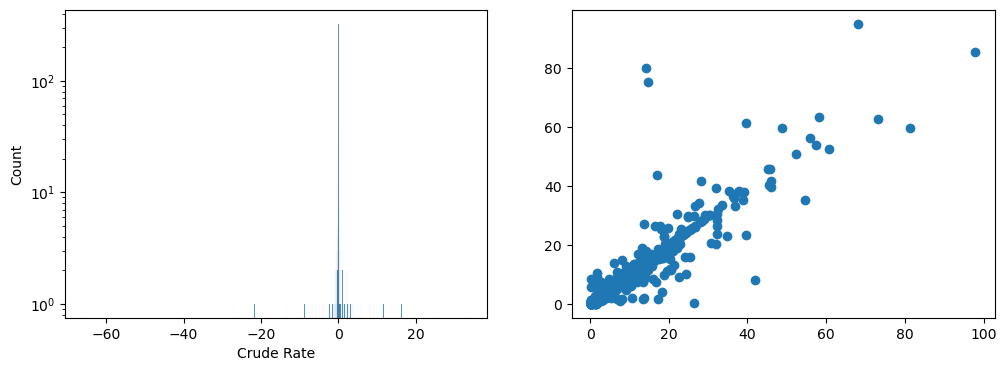

In [133]:
# visualize prediction vs actual: histplot and scatterplot (to visually inspect how model does)
# y_actual: array-like of actual predictions
def evaluate_model(y_pred, y_actual, model_name = 'default_model'):
    rmse = round(mean_squared_error(y_actual, y_pred, squared = False), 4)
    print(f"RMSE for {model_name} is {rmse}")
    
#     plt.figure(figsize=(16,4))
    # 1 row, 2 col visual
    fig, axes = plt.subplots(1,2, figsize = (12,4))
    axes[0].set_yscale('log') # set histplot on log scale to visualize - relatively bell-curved
#     axes[0].set_xscale('log')
    sns.histplot(y_actual-y_pred, ax = axes[0])
    plt.scatter(y_actual,y_pred)
    plt.show()
    

evaluate_model(y_pred, y_test['Crude Rate'], "base decision tree model")

In [135]:
# export the decision tree model to a tree_structure.dot file 
# paste the contents of the file to webgraphviz.com
export_graphviz(dec_tree_reg, out_file ='tree_structure.dot', 
               feature_names =x_train.columns)

In [151]:
# hyperparameter tuning
# Reference: https://www.nbshare.io/notebook/312837011/Decision-Tree-Regression-With-Hyper-Parameter-Tuning-In-Python/
# Can also use ExtraTreesRegressor to be more selective in features, if we had more 
parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
           "max_features":["log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

# function for calculating how much time take for hyperparameter tuning

def timer(start_time=None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)
        print(thour,":",tmin,':',round(tsec,2))



In [148]:

start_time = datetime.now()
tuning_dec_tree = GridSearchCV(dec_tree_reg,param_grid=parameters,scoring='neg_mean_squared_error',cv=3) #,verbose=3)

tuning_dec_tree.fit(x, y)

timer(start_time)

In [150]:
# best hyperparameters
print(tuning_dec_tree.best_params_)
print(tuning_dec_tree.best_score_)

{'max_depth': 7, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
-85.35351082616454


# Random Forest

In [153]:
# random forest with 1000 decision trees
rf_base = RandomForestRegressor(n_estimators = 1000, random_state = seed) #sklearn's RF

rf_base.fit(x_train, y_train['Crude Rate'])

RandomForestRegressor(n_estimators=1000, random_state=0)

RMSE for Random Forest Initial Model is 2.5124


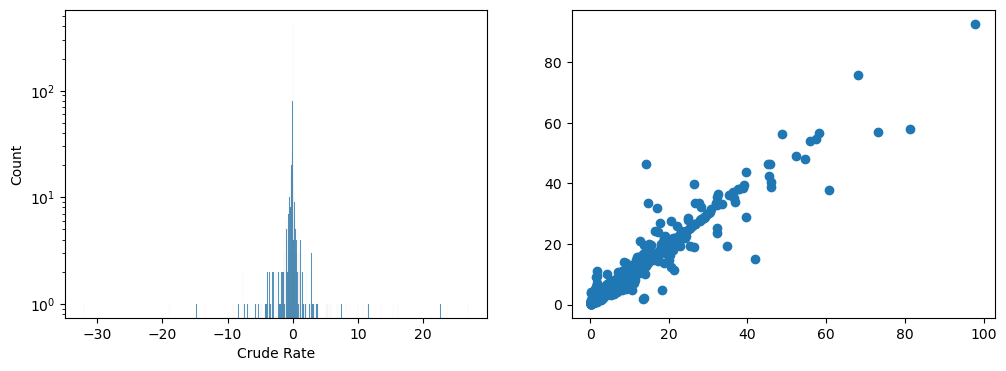

In [154]:
y_pred = rf_base.predict(x_test)
evaluate_model(y_pred, y_test['Crude Rate'], 'Random Forest Initial Model')

In [158]:
# hyperparameter tuning
param_grid = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [3,4,5,6,7,8],
    'criterion' :['friedman_mse', 'squared_error']
}


In [160]:

random_forest_tuner = RandomForestRegressor(random_state = seed)

start_time = datetime.now()
random_forest_grid = GridSearchCV(estimator=random_forest_tuner, param_grid=param_grid, cv=5)
random_forest_grid.fit(x_train, y_train['Crude Rate'])
print('Time to find best random forest parameters: ') # takes around 20 minutes
timer(start_time)

C:\Users\jared\.conda\envs\capstone_proj\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jared\.conda\envs\capstone_proj\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jared\.conda\envs\capstone_proj\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\jared\.conda\envs\capstone_proj\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_paramet

Time to find best random forest parameters: 
0.0 : 2.0 : 27.71


In [161]:
print(random_forest_grid.best_params_)
print(random_forest_grid.best_score_)

{'criterion': 'friedman_mse', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 500}
0.7034547134433924
